In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
#Geometery classes

#A cylinder of height 14 m and radius 6.55 m (all units in cm)
class OuterDetector:
    def __init__(self, radius=655.0, height=1402.0): #in cm
        self.radius = radius
        self.height = height
        self.center = [0., 0., 0.]
        
#The cryostat or "inner detector"
#A sphere in the center of the water tank/outer detector of radius 2.23 m
class OuterCryostat:
    def __init__(self, OD,radius=223.0, centerOffset=0.): #in cm
        self.radius = radius
        self.position = OD.center
        self.position[2]+=centerOffset 
        
        
#OD = OuterDetector(radius=3200.0, height=1.0)
OD = OuterDetector()   
OC = OuterCryostat(OD)

In [21]:
#Particle classes
mwe_depth = 6010.0 #SNOlab depth in meters water equivalent (to convert to useful units from literature)
lambdaa = 825.0 #at 6000 mwe

lowlim = 1e-3 #Lower limit to sample theta from - arbitrarily small
uplim = 1.16 #Upper limit, decided so that only 1-in-10 years worth of muons will show up with theta greater than this
npoints = 100000
thetarad=np.linspace(lowlim, uplim, npoints)

MeiHime= np.cos(thetarad)*np.sin(thetarad)*( (8.60*1e-6)*np.exp(-(mwe_depth/1000)/(0.45*np.cos(thetarad)))+ (0.44*1e-6)*np.exp(-(mwe_depth/1000.0)/(0.87*np.cos(thetarad))) )/np.cos(thetarad)

MeiHime = MeiHime /np.sqrt(MeiHime.sum()**2.0) #Normalize the angular distribution to sample from

GenDiscRad = 3200.0 #32 m radius disc to generate muons on. 
#this has to be much larger than the detector to give an accurate muon angular flux 
#This was decided by setting the generation height and then looking at theta distribution to see when we drop below ~ 1-in-10 years accuracy (typical experiment lifetime)



class muon(object):
    def __init__(self, theta=0., phi=0., energy=1., position=np.array([0., 0., 2300.]), momentum=np.array([-1., 0., 0.])): #energy in GeV, it's mass in MeV
        self.theta = self.SetTheta()
        self.phi = np.random.sample()*np.pi*2.0 #Random number in [0,2pi]
        r = np.sqrt(np.random.sample())*GenDiscRad
        self.energy = energy
        self.position=position
        self.position[0]=np.sin(self.phi)*r#x position set by sin
        self.position[1]=np.cos(self.phi)*r #y position
        #print(self.position)
        self.momentum = np.array([-self.position[0], -self.position[1], 0.])
        self.momentum = self.momentum/np.sqrt(np.dot(self.momentum,self.momentum)) #normalize
        
        #Smear the phi of the vector by some amount (biasing WT)
        #phi_smear= np.random.sample()*2.0*np.pi*(np.random.sample())
        
        #above OD
        if((self.position[0]*self.position[0] + self.position[1]*self.position[1])<=OD.radius*OD.radius):
            phi_smear= np.random.sample()*2.0*np.pi
        else:
            phi_smear = np.arctan(OD.radius/np.sqrt(np.dot(position[:2], position[:2])) )*(2.0*np.random.sample()-1.0)
        c, s = np.cos(phi_smear), np.sin(phi_smear) #how much to smear by?
        ux, uy, uz = [0,0,1.0] #Need to rotate around z axis
        R = np.array([[c+ux*ux*(1.0-c), ux*uy*(1-c) - uz*s, ux*uz*(1-c) + uy*s], [uy*ux*(1-c)+uz*s, c+uy*uy *(1-c), uy*uz*(1-c)-ux*s], [uz*ux*(1-c) - uy*s, uz*uy*(1-c)+ux*s, c+uz*uz * (1-c) ]])#rotation matrix
        self.momentum = R.dot(self.momentum)
        #rotate it downwards now by the amount self.theta (following muon angular distribution)
        #i.e. about the axis pxz (axis out of page/into page)
        ux, uy, uz = np.cross([0,0,1], self.momentum)
        rotateDown = np.pi/2.0 - self.theta
        c, s = np.cos(rotateDown), np.sin(rotateDown)
        R = np.array([[c+ux*ux*(1.0-c), ux*uy*(1-c) - uz*s, ux*uz*(1-c) + uy*s], [uy*ux*(1-c)+uz*s, c+uy*uy *(1-c), uy*uz*(1-c)-ux*s], [uz*ux*(1-c) - uy*s, uz*uy*(1-c)+ux*s, c+uz*uz * (1-c) ]])#rotation matrix
        self.momentum = R.dot(self.momentum)
        

        #print(self.momentum)
    #in relativity... v/c
    def GetBeta(self):
        gamma = self.energy/0.10566
        return np.sqrt(1.0 - 1.0/(gamma**2.0))
    
    def SetTheta(self):
        return np.random.choice(np.linspace(thetarad[0],thetarad[-1], len(MeiHime)),p=MeiHime)
        

In [22]:
#Testing
muon1 = muon()
muon2 = muon()


thet_hist=[]
phi_hist=[]
z_hist=[]
for i in range(100): 
    muon2 = muon()
    thet_hist.append(muon2.theta*180/np.pi)
    phi_hist.append(muon2.phi*180/np.pi)
    z_hist.append(muon2.momentum[1])


In [44]:

#returns where on OC the particle hit it
def calc_intersect_OC(pos, mom):
    entry_set=False
    exit_set=False
    
    #Let's start a couple of cm above the radius of the outer cryostat of 223 cm
    tmin = (225 - pos[2])/mom[2]
    tmin = int(tmin)
    #Now, if we move > 2*Roc ~ 446 cm (steps are in cm) we miss the OC completely
    for t in range(tmin, tmin+500):
        point =pos+mom*t
        #print(np.sqrt(np.dot(point, point)))
        #print(OC.radius**2.0 -1.0 <=np.dot(point, point)<=OC.radius**2.0 +1.0)
        #print(OC.radius**2.0 -1.0 <=np.dot(point, point))
        #print(OC.radius**2.0 +1.0 >=np.dot(point, point))

        if( OC.radius-0.3<= np.sqrt(np.dot(point, point)) <= OC.radius+0.3):
            if(entry_set==False):
                entry=point
                entry_set=True
                #print('Entered OC')
                continue
            if(entry_set==True):
                exit=point
                exit_set=True
                #print('Exited OC')
                break
    if(entry_set ==True and exit_set==True):
        return entry, exit
    elif(point[2] < -OC.radius):
       #print("Does not intersect with OC")
        return False

def calc_intersect_OD(pos, mom):
    entry_set=False
    exit_set=False
    
    
    for t in range(20000000):
        point =pos+mom*t
        if(entry_set==True and exit_set==True): 
            return entry, exit
        #Intersection with roof
        if ((np.sqrt(np.dot(point[:2], point[:2]))<=OD.radius+1.0) and (OD.height/2.0 - 1.0<=point[2]<=OD.height/2.0 + 1.0)):
            entry=point
            entry_set=True
            #print('roof entry')
            continue
            #print(entry)
        #Intersection with walls
        if (entry_set==False):
            if (OD.radius-1.0 <=np.sqrt(np.dot(point[:2], point[:2]))<=OD.radius+1.0) and (-OD.height/2.0-1.<=point[2]<=OD.height/2.0+1.):
                entry=point
                entry_set=True
                #print('wall entry')
                continue
        if(OD.radius-1.0 <=np.sqrt(np.dot(point[:2], point[:2]))<=OD.radius+1.0) and (-OD.height/2.0 -1.0)<=point[2]<=(OD.height/2.0 +1.0):
            exit = point
            exit_set = True
            #print('wall exit')
            continue
        #Intersection with floor
        if ((np.sqrt(np.dot(point[:2], point[:2]))<=OD.radius +1.0) and (-OD.height/2.0 - 1.0<=point[2]<=-OD.height/2.0 + 1.0)):
            exit=point
            exit_set=True
            #print('floor exit')
            return entry, exit
        if(point[2]< (-OD.height/2.0 -1.0)):
            #print("Does not intersect with OD")
            return False

def calc_intersect_disc(pos, mom, height, radius):
    t = (height - pos[2])/mom[2] #z_pos + p_z*t = height
    x_new = pos[0]+mom[0]*t 
    y_new = pos[1]+mom[1]*t
    if( (x_new*x_new + y_new*y_new < radius*radius) and t>=0.):
        return np.array([x_new, y_new, pos[2]+mom[2]*t]) #intersection point
    else:
        return False

#(x+pxt)^2 + (y+pyt)^2 = r^2
#x^2 + (pxt)^2 + 2pxt*x + y^2 + (pyt)^2 + 2pyt*x = r^2
# (x^2 + y^2 - r^2) + 2(xpx + ypy)t + (py^2+px^2))t^2


def calc_intersect_wall(pos, mom):
    a = mom[0]*mom[0] + mom[1]*mom[1]
    b = 2.0*(pos[0]*mom[0]+pos[1]*mom[1])
    c = pos[0]*pos[0] + pos[1]*pos[1] - OD.radius*OD.radius
    discriminant = b*b - 4.0*a*c
    
    if (discriminant<0): #doesn't intersect cylinder walls
        #print("discriminated")
        return False
  
    #Solve quadratic equation for t+-, if these yield intersections inside z range, keep
    t_pl = (-b + np.sqrt(discriminant))/(2.0*a)
    t_min = (-b - np.sqrt(discriminant))/(2.0*a)
    
    #print(t_min, t_pl)
    #print(pos+t_min*mom, pos+t_pl*mom)
    
    if(t_min<=0 and t_pl <=0):
        return False
    
    if (-OD.height/2.0<pos[2]<OD.height/2.0): #particle inside OD, take positive solution
        if(t_min>=0): #forward in time 
            x_new = pos[0]+mom[0]*t_min 
            y_new = pos[1]+mom[1]*t_min
            z_new = pos[2]+mom[2]*t_min
            return np.array([x_new, y_new, z_new])
        elif(t_pl>0): #unnecessary but safe
            x_new = pos[0]+mom[0]*t_pl
            y_new = pos[1]+mom[1]*t_pl
            z_new = pos[2]+mom[2]*t_pl
            return np.array([x_new, y_new, z_new])
        else:
            #print("Inside OD, what's going on with wall intersect?")
            return False
    
    #Cases for outside OD.
    z_new_min = pos[2]+t_min*mom[2]
    z_new_pl = pos[2]+t_pl*mom[2]
        
    if (t_min>=0 and t_pl>=0): # forward in time
        if((-OD.height/2.0<z_new_min<OD.height/2.0) and (-OD.height/2.0<z_new_pl<OD.height/2.0)):
            x_new = pos[0]+mom[0]*t_min
            y_new = pos[1]+mom[1]*t_min
            z_new = pos[2]+mom[2]*t_min
            entry = np.array([x_new, y_new, z_new])
            x_new = pos[0]+mom[0]*t_pl
            y_new = pos[1]+mom[1]*t_pl
            z_new = pos[2]+mom[2]*t_pl
            exit = np.array([x_new, y_new, z_new])
            return entry, exit
        
    if(t_min>=0 and (-OD.height/2.0<z_new_min<OD.height/2.0)):
        x_new = pos[0]+mom[0]*t_min 
        y_new = pos[1]+mom[1]*t_min
        return np.array([x_new, y_new, z_new_min])
    if(t_pl>=0 and (-OD.height/2.0<z_new_pl<OD.height/2.0)): #forward in time
        x_new = pos[0]+mom[0]*t_pl 
        y_new = pos[1]+mom[1]*t_pl
        return np.array([x_new, y_new, z_new_pl])

    return False
    
        
def calc_intersect_OD2(pos, mom): #Make use of quadratic equations and be more efficient
    entry_set, exit_set = False, False
    
    outside_start = pos[2]>OD.height/2. #particle is above OD
    
    if(outside_start == False): #photon etc...created inside OD.
        if mom[2]<0:
            floor_intersect = calc_intersect_disc(pos, mom, -OD.height/2., OD.radius)
        elif mom[2]>0:
            roof_intersect = calc_intersect_disc(pos, mom, OD.height/2., OD.radius)
        if(type(floor_intersect) != bool):
            return floor_intersect
        elif(type(roof_intersect) != bool):
            return roof_intersect
        else: #photon hits wall somewhere
            return calc_intersect_wall(pos, mom)
                

    if(outside_start):#check roof/floor first as these are fast
        #print("1")

        roof_intersect = calc_intersect_disc(pos, mom, OD.height/2., OD.radius)
        floor_intersect = calc_intersect_disc(pos, mom, -OD.height/2., OD.radius)
        
        if((pos[0]*pos[0] + pos[1]*pos[1] - OD.radius*OD.radius)<=0 and type(roof_intersect)==bool): #within radius upon start
            #print("2")
            return False #Can't intersect cylinder if misses roof in this case 
        
        elif(type(roof_intersect)!=bool):#hits roof
            entry = roof_intersect
            entry_set = True
            #print("roof")
            if(type(floor_intersect) != bool): #entered roof, exitted floor
                #print("roof and floor")
                return entry, floor_intersect #we are done! Lucky.
            else:#entered roof, exits wall
                #print("roof and wall")
                return entry, calc_intersect_wall(pos,mom)
                       
        elif(type(floor_intersect) != bool and type(roof_intersect)==bool): #didn't enter roof, but did exit floor
            exit = floor_intersect
            exit_set = True
            #print("wall and floor")
            #print(calc_intersect_wall(pos,mom), exit)
            if(type(calc_intersect_wall(pos,mom)) == bool):
                return False
            #Now there's only one option, it entered through the walls
            return calc_intersect_wall(pos,mom), exit
        else:#Only other option, it entered and exitted via the walls or missed the entire thing
            #print("7")
            #print(calc_intersect_wall(pos, mom))
            return calc_intersect_wall(pos, mom)
            


In [45]:
#Testing
muon1 = muon()
        
#print('about to while...')
while(calc_intersect_OD2(muon1.position, muon1.momentum) == False):
    #print('while..')
    muon1=muon()

#calc_intersect_OC(muon1.position, muon1.momentum)
#calc_intersect_OD(muon1.position, muon1.momentum)


#np.sqrt(muon1.position[0]**2 + muon1.position[1]**2)
#muon1.momentum


In [47]:
mu=muon()
numEvents = 10000 #For a detector this size, 10,000 muons is something like 170 days worth of live time.

entries=np.zeros((numEvents, 3)) #entering water tank
exits=np.zeros((numEvents, 3)) #exiting water tank

cryoentries = np.zeros((numEvents, 3)) #entering cryostat/inner detector
cryoexits = np.zeros((numEvents, 3)) #exiting cryostat/inner detector

startingPos=np.zeros((numEvents, 3))#starting position of muons

thetas=np.zeros(numEvents) #Angle from zenith (vertical)

thetas2=np.zeros(numEvents) #just for tests

phis=np.zeros(numEvents) #phi is the angular coordinate around the vertical (z axis)

for ev in range(numEvents):
    if(ev%100==0): 
        print("iteration",ev)
        
    while(type(calc_intersect_OD2(mu.position, mu.momentum)) == (bool or None)):
        #print(type(calc_intersect_OD2(mu.position, mu.momentum)))
        mu=muon()


    #print(mu.position, mu.momentum)
    entries[ev][:]=calc_intersect_OD2(mu.position, mu.momentum)[0]
    exits[ev][:]=calc_intersect_OD2(mu.position, mu.momentum)[1]
    
    if type(calc_intersect_OC(mu.position, mu.momentum)) == (tuple): #Crossed through OC
        #print(calc_intersect_OC(mu.position, mu.momentum))
        cryoentries[ev][:] = calc_intersect_OC(mu.position, mu.momentum)[0]
        cryoexits[ev][:] = calc_intersect_OC(mu.position, mu.momentum)[1]
    
    thetas[ev]=np.arccos(np.dot(mu.momentum, [0.,0.,-1.])) 
    thetas2[ev]=mu.theta
    phis[ev]=mu.phi 
    startingPos[ev][:]=mu.position
    
    mu=muon()



('iteration', 0)
('iteration', 100)
('iteration', 200)
('iteration', 300)
('iteration', 400)
('iteration', 500)
('iteration', 600)
('iteration', 700)
('iteration', 800)
('iteration', 900)
('iteration', 1000)
('iteration', 1100)
('iteration', 1200)
('iteration', 1300)
('iteration', 1400)
('iteration', 1500)
('iteration', 1600)
('iteration', 1700)
('iteration', 1800)
('iteration', 1900)
('iteration', 2000)
('iteration', 2100)
('iteration', 2200)
('iteration', 2300)
('iteration', 2400)
('iteration', 2500)
('iteration', 2600)
('iteration', 2700)
('iteration', 2800)
('iteration', 2900)
('iteration', 3000)
('iteration', 3100)
('iteration', 3200)
('iteration', 3300)
('iteration', 3400)
('iteration', 3500)
('iteration', 3600)
('iteration', 3700)
('iteration', 3800)
('iteration', 3900)
('iteration', 4000)
('iteration', 4100)
('iteration', 4200)
('iteration', 4300)
('iteration', 4400)
('iteration', 4500)
('iteration', 4600)
('iteration', 4700)
('iteration', 4800)
('iteration', 4900)
('iteration'

<IPython.core.display.Javascript object>


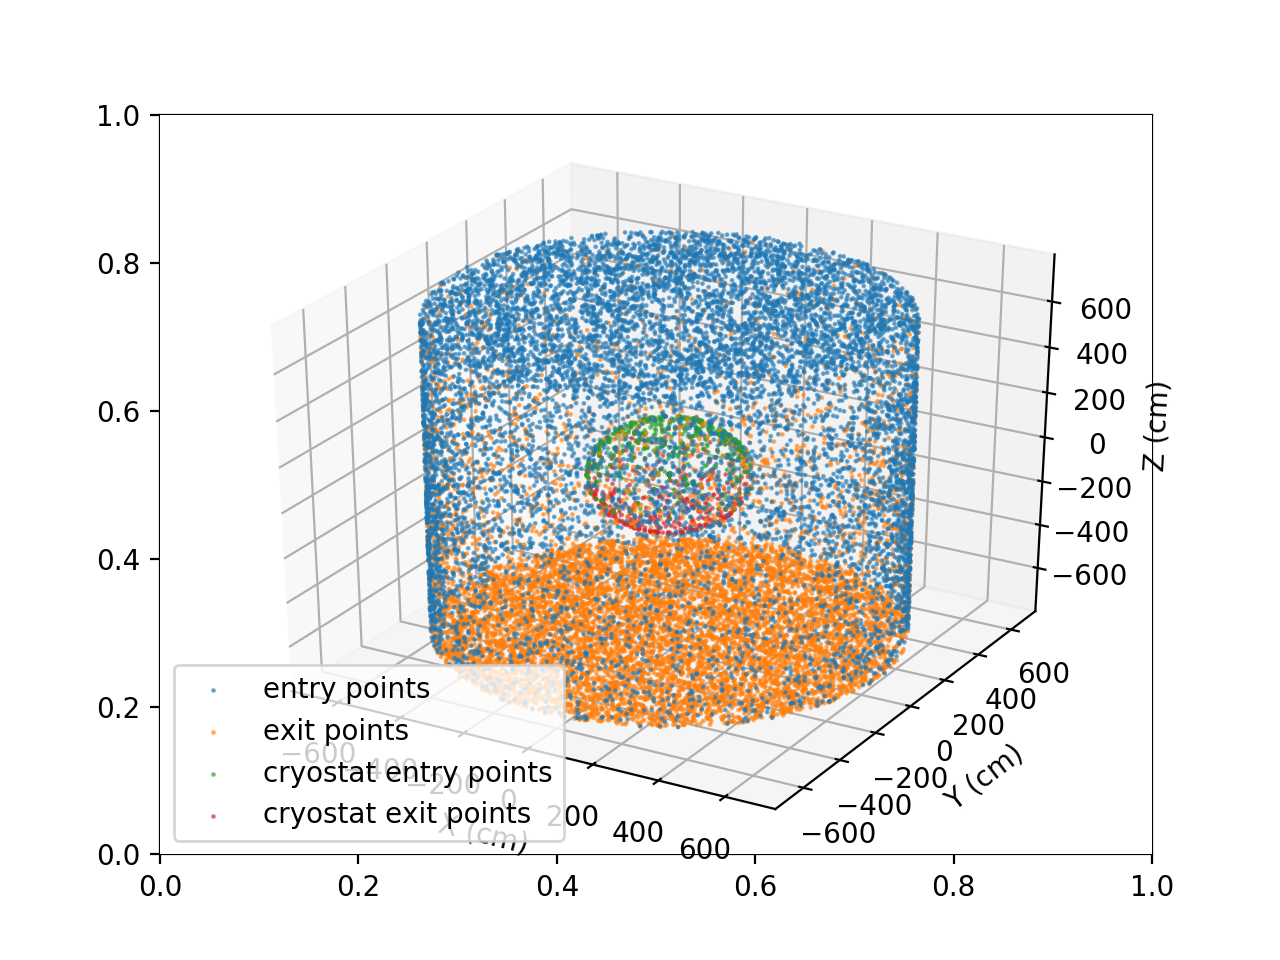

In [48]:
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, axisbg="1.0")
ax = fig.gca(projection='3d')
ax.scatter(entries[:,0],entries[:,1],entries[:,2], label='entry points', alpha=0.6, s=0.5)
ax.scatter(exits[:,0],exits[:,1],exits[:,2], label='exit points', alpha=0.6, s=0.5)
ax.scatter(cryoentries[:,0],cryoentries[:,1],cryoentries[:,2], label='cryostat entry points', alpha=0.6, s=0.5)
ax.scatter(cryoexits[:,0],cryoexits[:,1],cryoexits[:,2], label='cryostat exit points', alpha=0.6, s=0.5)
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')
plt.legend()
plt.show()
#plt.ion()
#plt.savefig("enteries_exits_10k_discSameAsODradius.pdf")


<IPython.core.display.Javascript object>


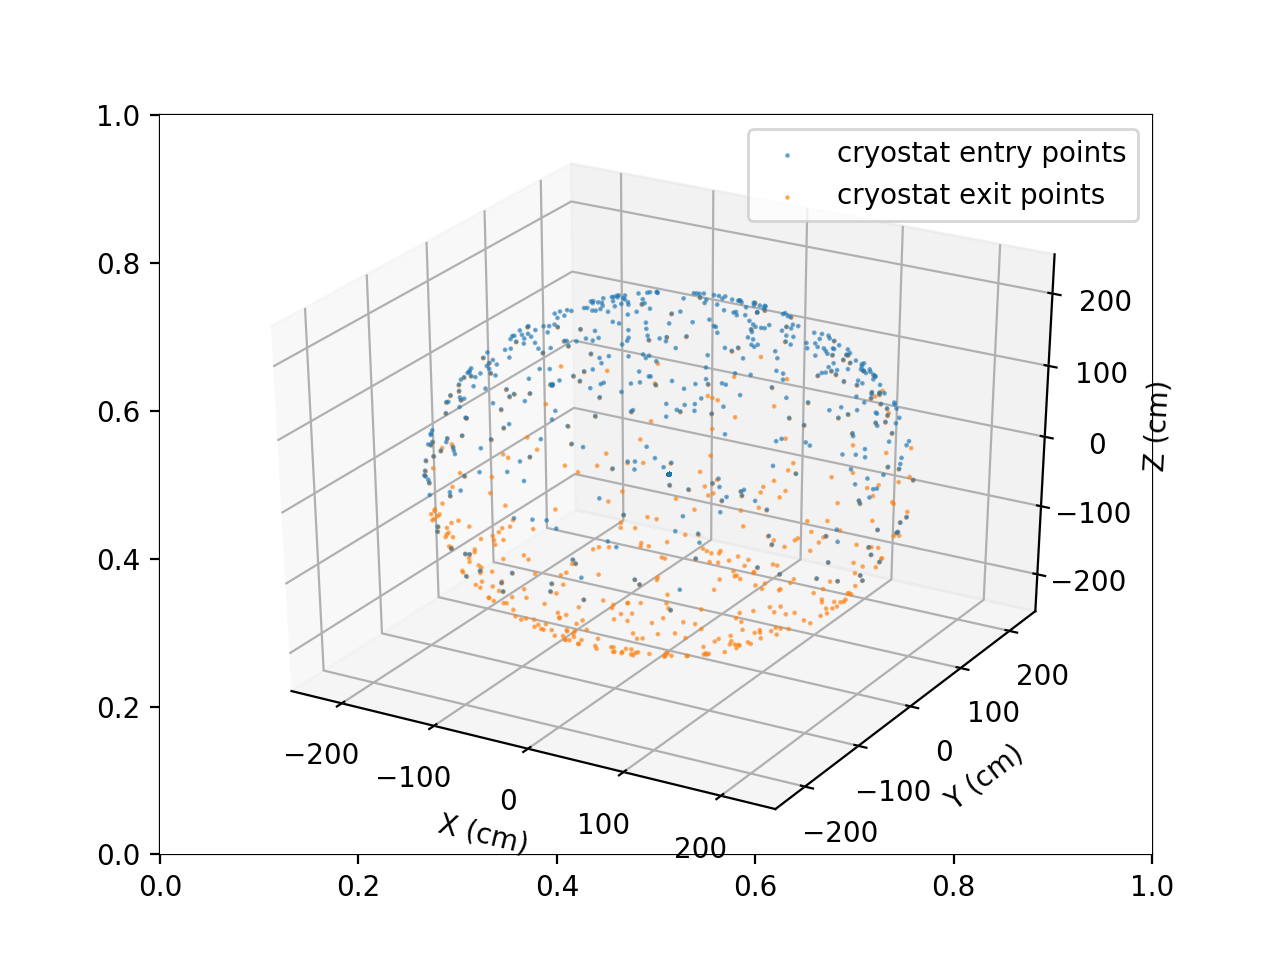

In [49]:
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, axisbg="1.0")
ax = fig.gca(projection='3d')
ax.scatter(cryoentries[:,0],cryoentries[:,1],cryoentries[:,2], label='cryostat entry points', alpha=0.6, s=0.5)
ax.scatter(cryoexits[:,0],cryoexits[:,1],cryoexits[:,2], label='cryostat exit points', alpha=0.6, s=0.5)
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')
plt.legend()
plt.show()

# Muon entry and exit points in the detector
Nice! Muons come from above and leave (mostly) through the floor. Just what we would expect for muons being generated from high above the detector.

In [11]:
#%%timeit
MeiHime_sample=np.zeros(numEvents)
for i in range(numEvents):
    MeiHime_sample[i]=np.random.choice(np.linspace(thetarad[0],thetarad[-1], len(MeiHime)),p=MeiHime)
    

<IPython.core.display.Javascript object>


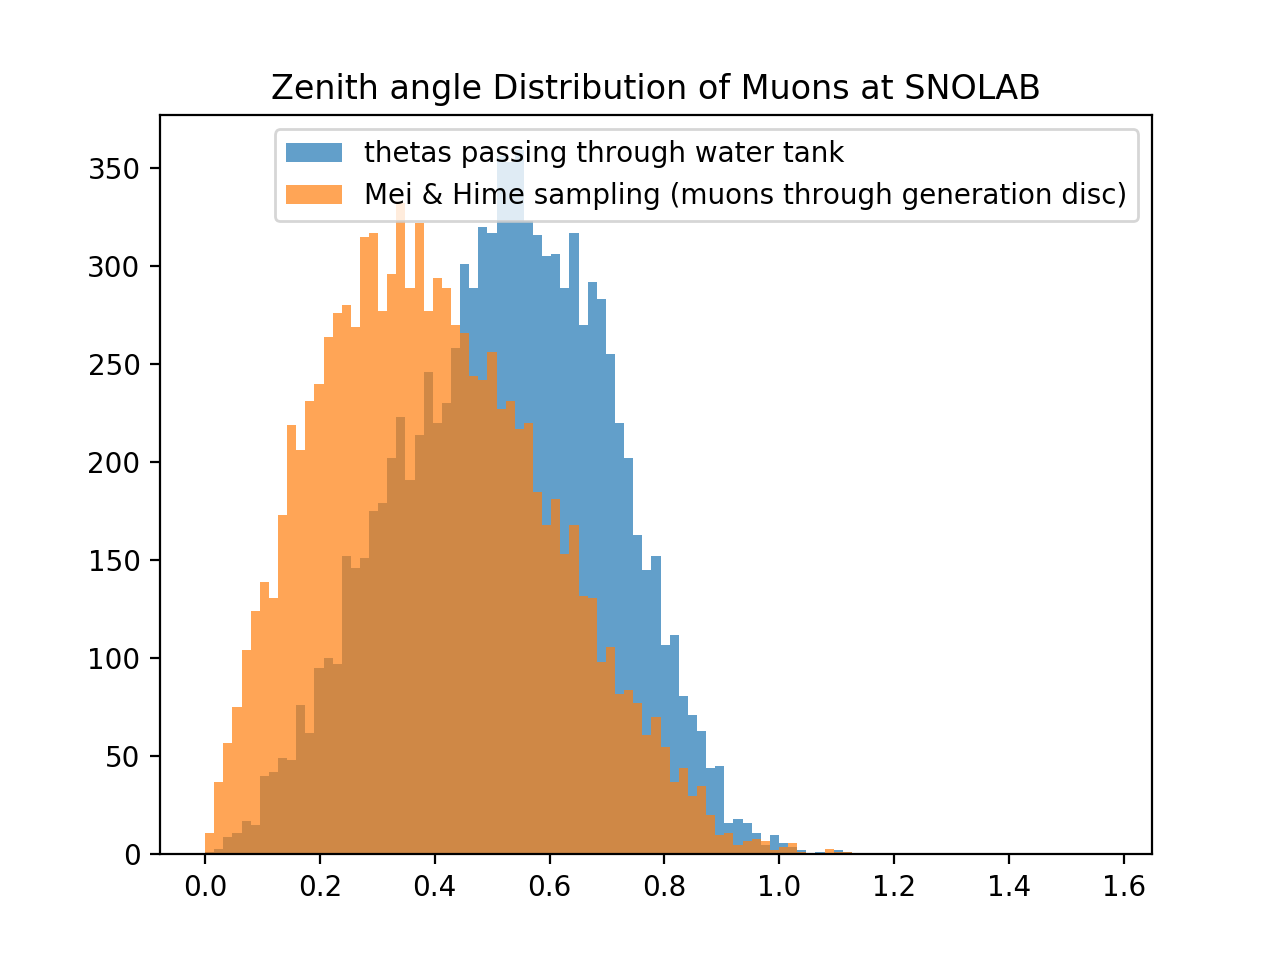

('Mean, std of thetas: ', 0.5229401314143143, 0.1818369672619193)


In [50]:
plt.clf()
#plt.hist(phis, bins=np.linspace(0, 2.0*np.pi, 100), label='phis', alpha=0.7)
plt.hist(thetas2, bins=np.linspace(0,np.pi/2.0, 100), label='thetas passing through water tank', alpha=0.7)
plt.hist(MeiHime_sample, bins=np.linspace(0,np.pi/2.0, 100), label='Mei & Hime sampling (muons through generation disc)', alpha=0.7)
plt.legend()
plt.title("Zenith angle Distribution of Muons at SNOLAB")
plt.show()
#plt.savefig("normal_OD_doubleGenR.pdf")
print("Mean, std of thetas: ",np.mean(thetas2), np.std(thetas2))

# Muon Angles from Zenith
This is interesting... The distribution that we are sampling from is in orange (muon angle from zenith), but the muons passing through our large upright cylindrical detector have thetas in blue. It looks like the muon flux isn't really straight forward to calculate through the water tank! This is important when generating light maps in the next notebook. If you could reconstruct the muon track perfectly well just from it's light map, we should recover the blue and not the orange distribution.

Also, the distribution dies off before ~1.2 radius cool! This is partially because muons coming in at such steep angles have to traverse much more rock (and therefore get attenuated out) as the travel from the upper atmosphere to the underground laboratory.